# Problem Understanding

#### What is the Airbnb business model?

- Marketplace: connect people offering homestays with people looking for homestays.
                  
- Gross Revenue = (Fee * Users) - CAC

# Libraries

In [98]:
import pandas as pd
import numpy as np
import seaborn as sns

from IPython.display import Image
from matplotlib import pyplot as plt

## Helper Functions

## Loading Data

In [3]:
data_raw_age_gender = pd.read_csv("datasets/age_gender_bkts.csv", low_memory=False)
data_raw_age_gender

,age_bucket,country_destination,gender,population_in_thousands,year
0,100+,AU,male,1.0,2015.0
1,95-99,AU,male,9.0,2015.0
2,90-94,AU,male,47.0,2015.0
3,85-89,AU,male,118.0,2015.0
4,80-84,AU,male,199.0,2015.0
...,...,...,...,...,...
415,95-99,US,male,115.0,2015.0
416,90-94,US,male,541.0,2015.0
417,15-19,US,female,10570.0,2015.0
418,85-89,US,male,1441.0,2015.0


In [4]:
data_raw_countries = pd.read_csv("datasets/countries.csv", low_memory=False)
data_raw_countries

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06
5,GB,54.633220,-3.432277,6883.6590,243610.0,eng,0.00
6,IT,41.873990,12.564167,8636.6310,301340.0,ita,89.40
7,NL,52.133057,5.295250,7524.3203,41543.0,nld,63.22
8,PT,39.553444,-7.839319,7355.2534,92090.0,por,95.45
9,US,36.966427,-95.844030,0.0000,9826675.0,eng,0.00


In [5]:
data_raw_sample_submission = pd.read_csv("datasets/sample_submission_NDF.csv", low_memory=False)
data_raw_sample_submission

,id,country
0,5uwns89zht,NDF
1,jtl0dijy2j,NDF
2,xx0ulgorjt,NDF
3,6c6puo6ix0,NDF
4,czqhjk3yfe,NDF
...,...,...
62091,cv0na2lf5a,NDF
62092,zp8xfonng8,NDF
62093,fa6260ziny,NDF
62094,87k0fy4ugm,NDF


In [9]:
data_raw_sessions = pd.read_csv("datasets/sessions.csv", low_memory=True)
data_raw_sessions

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0
...,...,...,...,...,...,...
10567732,9uqfg8txu3,dashboard,view,dashboard,Windows Desktop,556.0
10567733,9uqfg8txu3,edit,view,edit_profile,Windows Desktop,6624.0
10567734,9uqfg8txu3,webcam_upload,-unknown-,-unknown-,Windows Desktop,200125.0
10567735,9uqfg8txu3,active,-unknown-,-unknown-,-unknown-,17624.0


In [7]:
data_raw_test_users = pd.read_csv("datasets/test_users.csv", low_memory=False)
data_raw_test_users

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,20140701000148,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
3,6c6puo6ix0,2014-07-01,20140701000215,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE
4,czqhjk3yfe,2014-07-01,20140701000305,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62091,cv0na2lf5a,2014-09-30,20140930235232,NaN,-unknown-,31.0,basic,0,en,direct,direct,untracked,Web,Windows Desktop,IE
62092,zp8xfonng8,2014-09-30,20140930235306,NaN,-unknown-,NaN,basic,23,ko,direct,direct,untracked,Android,Android Phone,-unknown-
62093,fa6260ziny,2014-09-30,20140930235408,NaN,-unknown-,NaN,basic,0,de,direct,direct,linked,Web,Windows Desktop,Firefox
62094,87k0fy4ugm,2014-09-30,20140930235430,NaN,-unknown-,NaN,basic,0,en,sem-brand,google,omg,Web,Mac Desktop,Safari


In [8]:
data_raw_train_users = pd.read_csv("datasets/train_users_2.csv", low_memory=False)
data_raw_train_users

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213446,zxodksqpep,2014-06-30,20140630235636,NaN,MALE,32.0,basic,0,en,sem-brand,google,omg,Web,Mac Desktop,Safari,NDF
213447,mhewnxesx9,2014-06-30,20140630235719,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome,NDF
213448,6o3arsjbb4,2014-06-30,20140630235754,NaN,-unknown-,32.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,NDF
213449,jh95kwisub,2014-06-30,20140630235822,NaN,-unknown-,NaN,basic,25,en,other,other,tracked-other,iOS,iPhone,Mobile Safari,NDF


#### Could we merge sesions with train_users?

Sessions and train_users are our main tables. We are going to use both of them in this project. Yet, we cannot merge these tables now because they have different granularity: 

**(1)** train_user is user-level (informations are: one user per row). 

**(2)** sessions is secs_elapsed-level (informations are related to action, action_type, action_detail, device_type and secs_elapse - and this one is the highest level).

To merge the two tables, we need to encoding the columns from sessions. 

In [13]:
# train user
data_raw_train_users[data_raw_train_users["id"] == "nw9fwlyb5f"]

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
213450,nw9fwlyb5f,2014-06-30,20140630235824,NaN,-unknown-,NaN,basic,25,en,direct,direct,untracked,iOS,iPhone,-unknown-,NDF


In [14]:
# sessions
data_raw_sessions[data_raw_sessions["user_id"] == "nw9fwlyb5f"].head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
5555239,nw9fwlyb5f,show,view,user_profile,iPhone,9310.0
5555240,nw9fwlyb5f,show,view,p3,iPhone,33.0
5555241,nw9fwlyb5f,reviews,data,listing_reviews,iPhone,8.0
5555242,nw9fwlyb5f,campaigns,NaN,NaN,iPhone,41983.0
5555243,nw9fwlyb5f,click,click,book_it,iPhone,58491.0


In [16]:
# sessions
data_raw_sessions[(data_raw_sessions["user_id"] == "nw9fwlyb5f") & (data_raw_sessions["action"] == "reviews")].head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
5555241,nw9fwlyb5f,reviews,data,listing_reviews,iPhone,8.0
5555269,nw9fwlyb5f,reviews,data,listing_reviews,iPhone,11.0


# 1. Data Description

In [67]:
df1 = data_raw_train_users.copy()

### Data fields meaning

- id: user id.

- date_account_created: the date of account creation.

- timestamp_first_active: timestamp of the first activity, note that it can be earlier than date_account_created or - date_first_booking because a user can search before signing up.

- date_first_booking: date of first booking.

- gender.

- age.

- signup_method.

- signup_flow: the page a user came to signup up from.

- language: international language preference.

- affiliate_channel: what kind of paid marketing.

- affiliate_provider: where the marketing is e.g. google, craigslist, other.

- first_affiliate_tracked: whats the first marketing the user interacted with before the signing up.

- signup_app.

- first_device_type.

- first_browser.

- country_destination: this is the target variable you are to predict.

df1.columns

## 1.1. Data Dimensions

In [68]:
print("Number of rows: {}".format(df1.shape[0]))
print("Number of cols: {}".format(df1.shape[1]))

Number of rows: 213451
Number of cols: 16


## 1.2. Data Types

In [69]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [70]:
df1.sample(3)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
172389,mzn2dx9t00,2014-04-06,20140406183225,NaN,FEMALE,41.0,facebook,12,en,direct,direct,untracked,iOS,iPhone,-unknown-,NDF
165755,z9xamqpwpr,2014-03-20,20140320233805,2014-03-21,-unknown-,NaN,basic,8,en,direct,direct,untracked,Web,Android Tablet,IE,IT
156509,e8zn6wja1g,2014-02-25,20140225001358,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Mac Desktop,Firefox,NDF


## 1.3. NA Check

In [71]:
df1.isna().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

## 1.4. Removing NA

As we want to deliver a solution as faster as possible, we will remove all NA values in this cycle. However, we may treat NA values using a different technique as next steps.

In [72]:
df1 = df1.dropna()

In [73]:
df1.shape

(68171, 16)

## 1.5. Change Data Type

In [74]:
# date_account_created
df1["date_account_created"] = pd.to_datetime(df1["date_account_created"])

# timestamp_first_active
df1["timestamp_first_active"] = pd.to_datetime(df1["timestamp_first_active"], format="%Y%m%d%H%M%S")

# date_first_booking
df1["date_first_booking"] = pd.to_datetime(df1["date_first_booking"])

# age
df1["age"] = df1["age"].astype(int)

In [75]:
df1.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

## 1.6. Check Balanced Data

In [76]:
df1["country_destination"].value_counts()

US       48324
other     7557
FR        3687
IT        2029
GB        1768
ES        1695
CA        1070
DE         849
NL         600
AU         434
PT         158
Name: country_destination, dtype: int64

In [77]:
df1["country_destination"].value_counts(normalize=True)

US       0.708864
other    0.110854
FR       0.054085
IT       0.029763
GB       0.025935
ES       0.024864
CA       0.015696
DE       0.012454
NL       0.008801
AU       0.006366
PT       0.002318
Name: country_destination, dtype: float64

- This is a multi-class (many types for the target variable) and very unbalanced (70% of data only for US, for instance). This is a very complex classification problem. 

- Since NDF (no destination found) was a type of country_destination, it is not in our dataset anymore because it belongs to users which did not make their first booking - and we removed these NA values. 

## 1.7. Descriptive Statistics

In [78]:
num_attributes = df1.select_dtypes(include=["int64", "float64"])
cat_attributes = df1.select_dtypes(exclude=["int64", "float64", "datetime64[ns]"])

In [79]:
num_attributes.columns

Index(['age', 'signup_flow'], dtype='object')

In [80]:
cat_attributes.columns

Index(['id', 'gender', 'signup_method', 'language', 'affiliate_channel',
       'affiliate_provider', 'first_affiliate_tracked', 'signup_app',
       'first_device_type', 'first_browser', 'country_destination'],
      dtype='object')

### 1.7.1. Numerical attributes

In [81]:
# Central tendency metrics
c1 = pd.DataFrame(num_attributes.apply( np.mean )).T
c2 = pd.DataFrame(num_attributes.apply( np.median )).T

# Dispersion metrics
d1 = pd.DataFrame(num_attributes.apply( np.std )).T
d2 = pd.DataFrame(num_attributes.apply(lambda x: x.min() )).T
d3 = pd.DataFrame(num_attributes.apply(lambda x: x.max() )).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() )).T

# Concatenate metric
m = pd.concat([d2, d3, d4, c1, c2, d1, d5, d6]).T.reset_index()
m.columns = ["attributes", "min", "max", "range", "mean", "median", "std", "skewness", "kurtosis"]

In [82]:
m

,attributes,min,max,range,mean,median,std,skewness,kurtosis
0,age,2.0,2014.0,2012.0,47.857593,33.0,146.035312,13.250136,175.132153
1,signup_flow,0.0,25.0,25.0,2.436857,0.0,6.533959,2.807117,6.439075


- We have maximum age as 2014. This is probably wrong.
- As median is less than mean, we have a left skew: positive skewness. 
- Since age has a 175 value for kurtosis, we have a very high peak.

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


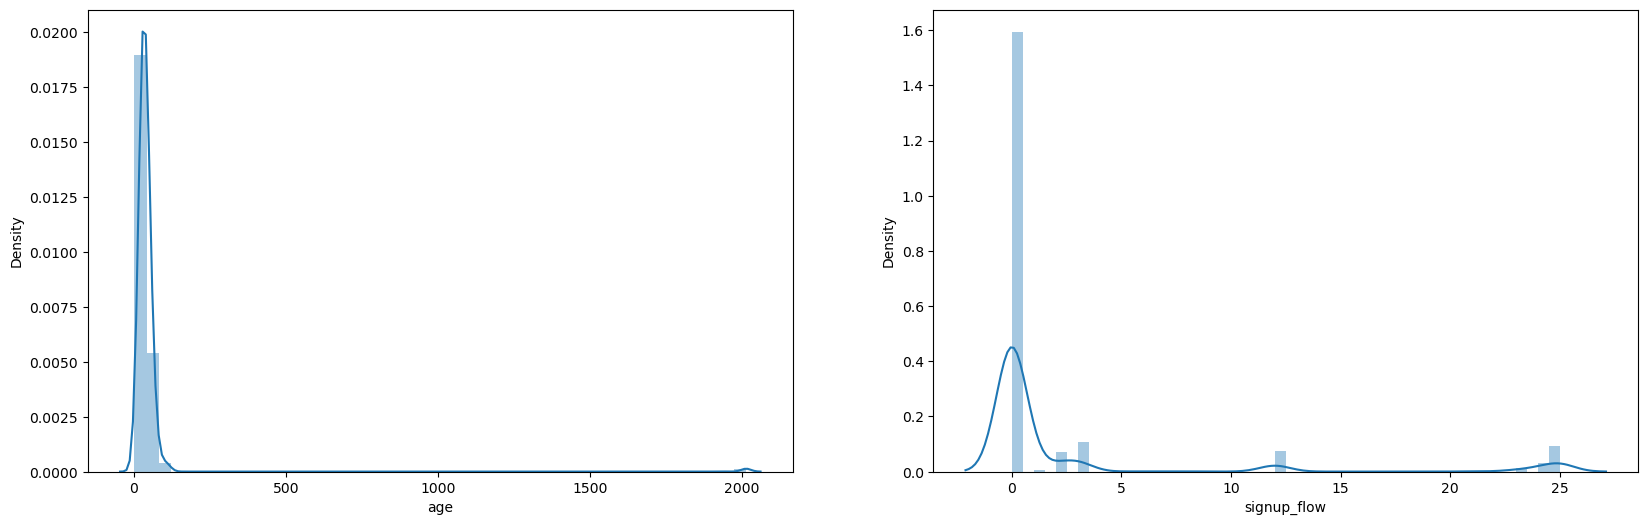

In [88]:
plt.figure(figsize = (20,6))

plt.subplot(121)
sns.distplot(df1["age"])

plt.subplot(122)
sns.distplot(df1["signup_flow"])

plt.subplots_adjust(wspace = 0.2)

In [89]:
df1["age"].value_counts().sort_values()

1926       1
2008       1
1938       1
16         1
1931       1
        ... 
28      3392
29      3423
32      3449
31      3531
30      3641
Name: age, Length: 117, dtype: int64

We may have lower ages ( <= 2 years old, for instance) in our dataset because they are children accompanied by parents. Yet, we may not have ages higher than 122, since this age is for the oldest person who ever lived on Earth. Thus, these values will be treated as outliers.

In [90]:
df1 = df1[df1["age"] <= 122]

In [91]:
df1.shape

(67797, 16)

### 1.7.2. Categorical attributes

In [92]:
cat_attributes.apply(lambda x: x.unique().shape[0] )

id                         68171
gender                         4
signup_method                  3
language                      23
affiliate_channel              8
affiliate_provider            16
first_affiliate_tracked        7
signup_app                     4
first_device_type              9
first_browser                 36
country_destination           11
dtype: int64

In [95]:
cat_attributes.drop(columns="id").apply(lambda x: x.unique() )

gender                                      [FEMALE, -unknown-, MALE, OTHER]
signup_method                                      [basic, facebook, google]
language                   [en, es, fr, zh, ko, de, it, ja, pt, ru, nl, s...
affiliate_channel          [direct, other, seo, sem-non-brand, content, s...
affiliate_provider         [direct, craigslist, google, other, facebook, ...
first_affiliate_tracked    [untracked, omg, linked, tracked-other, produc...
signup_app                                        [Web, Moweb, iOS, Android]
first_device_type          [Windows Desktop, Mac Desktop, iPhone, Desktop...
first_browser              [IE, Firefox, Chrome, Safari, -unknown-, Mobil...
country_destination          [US, other, CA, FR, IT, ES, GB, NL, DE, AU, PT]
dtype: object

# 2. Feature Engineering

In [97]:
df2 = df1.copy()

## 2.1. Hypotheses Mind Map

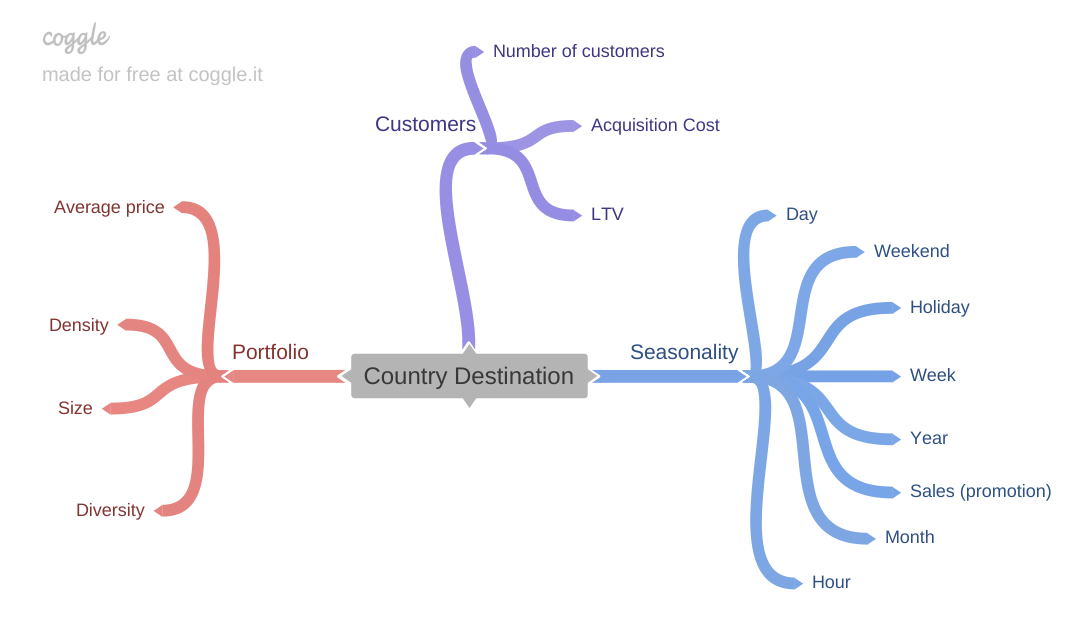

In [99]:
Image("images/AirbnbMindMap.png")

# 3. Feature Filtering and Selection

# 4. Exploratory Data Analysis (EDA)

# 5. Data Preparation

# 6. Feature Selection

# 7. Machine Learning Modeling

Artifical Neural Network (ANN) - Multi-Layer Perceptron (MLP)

## 7.1. ANN Performance